 ## Подготовка среды и импорт библиотек

In [1]:
# Установка PySpark в Google Colab
!pip install pyspark

# Импорт необходимых библиотек
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lower, trim, when, count, to_date, regexp_extract, isnan
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Создание Spark сессии
spark = SparkSession.builder \
    .appName("COVID-19 X-Ray Analysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print(f"Версия Spark: {spark.version}")
print("Spark сессия успешно создана!")

Версия Spark: 3.5.1
Spark сессия успешно создана!


## Загрузка и предварительный просмотр данных

In [2]:
# Скачиваем CSV через pandas
data_url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv"

# Загружаем через pandas
pdf = pd.read_csv(data_url)

# Преобразуем pandas DataFrame в Spark DataFrame
df = spark.createDataFrame(pdf)

# Выводим структуру
print("Схема данных:")
df.printSchema()

print(f"\nВсего записей: {df.count()}")

print("\nПервые 10 строк:")
df.show(10, truncate=False)

Схема данных:
root
 |-- patientid: string (nullable = true)
 |-- offset: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: strin

## Предобработка даных

In [5]:
spark = SparkSession.builder.getOrCreate()

# работаем с исходным df
df_clean = df

# Заполнение пропусков
categorical_cols = ['sex', 'finding', 'modality', 'view', 'location']
categorical_cols = [c for c in categorical_cols if c in df_clean.columns]
df_clean = df_clean.fillna("unknown", subset=categorical_cols)

numeric_cols = [
    'age', 'offset', 'temperature', 'pO2_saturation',
    'leukocyte_count', 'neutrophil_count', 'lymphocyte_count'
]

for c in numeric_cols:
    if c in df_clean.columns:
        non_null_count = df_clean.filter(col(c).isNotNull()).count()
        if non_null_count > 0:
            median_val = df_clean.approxQuantile(c, [0.5], 0.01)[0]
            if median_val is not None:
                df_clean = df_clean.fillna({c: float(median_val)})
        else:
            df_clean = df_clean.fillna({c: 0.0})

# Восстановление NULL в клинических флагах
clinical_flag_cols = [
    'RT_PCR_positive', 'survival', 'intubated', 'intubation_present',
    'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated'
]
for c in clinical_flag_cols:
    if c in df_clean.columns:
        df_clean = df_clean.replace("unknown", None, subset=[c])

# Унификация диагнозов
df_clean = df_clean.withColumn(
    "finding",
    when(col("finding").isNull() | (trim(col("finding")) == ""), "unknown")
    .when(lower(col("finding")).contains("covid") |
          lower(col("finding")).contains("2019-ncov") |
          lower(col("finding")).contains("sars-cov-2"), "COVID-19 pneumonia")
    .when(lower(col("finding")).contains("sars"), "SARS pneumonia")
    .when(lower(col("finding")).contains("pneumonia"), "Other pneumonia")
    .otherwise(col("finding"))
)

# Удаление дубликатов и артефактов
key_cols = ["patientid", "offset", "date", "filename"]
df_clean = df_clean.dropDuplicates(subset=key_cols)

if "Unnamed: 29" in df_clean.columns:
    df_clean = df_clean.drop("Unnamed: 29")

df_clean = df_clean.fillna("", subset=["clinical_notes", "other_notes"])

print(f"Исходных записей: {df.count()}")
print(f"После очистки: {df_clean.count()}")

Исходных записей: 950
После очистки: 950


## Анализ качества

In [6]:
# Добавляем год один раз
df_clean = df_clean.withColumn("year", regexp_extract(col("date"), r"(\d{4})", 1).cast("int"))

# Анализ пропусков
def count_nulls(df):
    return df.select([
        count(when(col(c).isNull() | (col(c).cast(StringType()) == ""), c)).alias(c)
        for c in df.columns
    ])

print("=== Распределение пропущенных значений ===")
count_nulls(df_clean).show(truncate=False)

# Анализ аномалий
print("\n=== АНАЛИЗ АНОМАЛИЙ ===")

print("\n[Аномалии в `patientid`]:")
df_clean.filter(
    (col("patientid").isNull()) |
    (col("patientid") == "") |
    (~col("patientid").rlike(r"^\d+$"))
).select("patientid", "filename", "finding").show(truncate=False)

print("\n[Распределение по `sex`]:")
df_clean.groupBy("sex").count().orderBy("count", ascending=False).show()

print("\n[Распределение диагнозов `finding`]:")
df_clean.groupBy("finding").count().orderBy("count", ascending=False).show(truncate=False)

print("\n[Распределение проекций `view`]:")
df_clean.groupBy("view").count().show()

print("\n[Парсинг дат]:")
parsed = df_clean.filter(col("year").isNotNull()).count()
print(f"Успешно извлечено годов: {parsed} из {df_clean.count()}")

=== Распределение пропущенных значений ===
+---------+------+---+---+-------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----+--------+------+--------+---+---+-------+--------------+-----------+----+
|patientid|offset|sex|age|finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|date|location|folder|filename|doi|url|license|clinical_notes|other_notes|year|
+---------+------+---+---+-------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----+--------+------+--------+---+---+-------+--------------+-----------+----+
|0        |0     |0  |0  |0      |0 

## SQL аналитика

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.getOrCreate()

# Убедимся, что колонка `year` существует
if "year" not in df_clean.columns:
    df_clean = df_clean.withColumn("year", regexp_extract(col("date"), r"(\d{4})", 1).cast(IntegerType()))

# Регистрация временной таблицы
df_clean.createOrReplaceTempView("covid_metadata")

# Запрос 1: Базовая статистика по диагнозам
print("Запрос 1: Базовая статистика по диагнозам")
q1 = spark.sql("""
    SELECT
        finding,
        COUNT(*) AS total_cases,
        ROUND(AVG(age), 1) AS avg_age,
        ROUND(MIN(age), 1) AS min_age,
        ROUND(MAX(age), 1) AS max_age
    FROM covid_metadata
    WHERE finding != 'unknown'
    GROUP BY finding
    ORDER BY total_cases DESC
""")
q1.show(truncate=False)

# Запрос 2: Распределение по полу и диагнозам
print("\n Запрос 2: Распределение по полу и диагнозам")
q2 = spark.sql("""
    SELECT
        finding,
        sex,
        COUNT(*) AS count
    FROM covid_metadata
    WHERE finding != 'unknown' AND sex NOT IN ('unknown', '')
    GROUP BY finding, sex
    ORDER BY finding, count DESC
""")
q2.show(truncate=False)

# Запрос 3: Топ-3 по возрасту в каждой группе диагнозов
print("\nЗапрос 3: Топ-3 самых пожилых пациентов в каждой группе диагнозов")
q3 = spark.sql("""
    WITH ranked_patients AS (
        SELECT
            patientid,
            age,
            sex,
            finding,
            ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) AS rn
        FROM covid_metadata
        WHERE finding != 'unknown' AND age IS NOT NULL AND patientid IS NOT NULL
    )
    SELECT
        finding,
        patientid,
        age,
        sex
    FROM ranked_patients
    WHERE rn <= 3
    ORDER BY finding, age DESC
""")
q3.show(truncate=False)

# Запрос 4: Временные тренды по годам
print("\nЗапрос 4: Временные тренды по годам и диагнозам")
q4 = spark.sql("""
    SELECT
        year,
        finding,
        COUNT(*) AS num_studies
    FROM covid_metadata
    WHERE year IS NOT NULL AND finding != 'unknown'
    GROUP BY year, finding
    ORDER BY year, num_studies DESC
""")
q4.show(truncate=False)

# Запрос 5: Проекции (view) и диагнозы
print("\nЗапрос 5: Связь проекций снимков и диагнозов")
q5 = spark.sql("""
    SELECT
        view,
        finding,
        COUNT(*) AS count
    FROM covid_metadata
    WHERE view NOT IN ('unknown', '') AND finding != 'unknown'
    GROUP BY view, finding
    ORDER BY view, count DESC
""")
q5.show(truncate=False)

Запрос 1: Базовая статистика по диагнозам
+------------------+-----------+-------+-------+-------+
|finding           |total_cases|avg_age|min_age|max_age|
+------------------+-----------+-------+-------+-------+
|COVID-19 pneumonia|584        |55.8   |20.0   |94.0   |
|Other pneumonia   |226        |49.2   |18.0   |90.0   |
|todo              |83         |54.0   |54.0   |54.0   |
|No Finding        |22         |52.5   |22.0   |78.0   |
|Tuberculosis      |18         |43.1   |20.0   |78.0   |
|SARS pneumonia    |16         |50.1   |23.0   |76.0   |
|Unknown           |1          |54.0   |54.0   |54.0   |
+------------------+-----------+-------+-------+-------+


 Запрос 2: Распределение по полу и диагнозам
+------------------+---+-----+
|finding           |sex|count|
+------------------+---+-----+
|COVID-19 pneumonia|M  |346  |
|COVID-19 pneumonia|F  |175  |
|COVID-19 pneumonia|NaN|63   |
|No Finding        |M  |11   |
|No Finding        |F  |10   |
|No Finding        |NaN|1    |
|Othe

## Обработка в PySpark с UDF

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType

spark = SparkSession.builder.getOrCreate()


# 1. UDF: категоризация возраста

def categorize_age(age):
    if age is None:
        return "unknown"
    if age < 0 or age > 120:
        return "invalid"
    if age < 18:
        return "child"
    elif age < 40:
        return "young_adult"
    elif age < 65:
        return "middle_aged"
    else:
        return "senior"

age_group_udf = udf(categorize_age, StringType())


# 2. UDF: унификация диагнозов (альтернатива SQL-when)

def normalize_finding(finding):
    if not finding or finding.strip() == "" or finding == "unknown":
        return "unknown"
    f = finding.lower()
    if "covid" in f or "2019-ncov" in f or "sars-cov-2" in f:
        return "COVID-19 pneumonia"
    elif "sars" in f:
        return "SARS pneumonia"
    elif "pneumonia" in f:
        return "Other pneumonia"
    else:
        return finding.strip()

normalize_finding_udf = udf(normalize_finding, StringType())


# 3. Применение UDF и фильтрация

df_processed = (
    df
    .filter(col("patientid").isNotNull())  # только реальные пациенты
    .withColumn("finding", normalize_finding_udf(col("finding")))
    .withColumn("age_group", age_group_udf(col("age")))
    .filter(col("finding") != "unknown")  # опционально: исключить неопределимые диагнозы
)


# 4. Сохранение в оптимизированном формате

output_path = "/mnt/data/covid_metadata_processed"

(
    df_processed
    .repartition(col("finding"))  # улучшает читаемость при фильтрации по finding
    .write
    .mode("overwrite")
    .partitionBy("finding")
    .parquet(output_path)
)

print(f"Обработанные данные сохранены в: {output_path}")
print(f" Обработано записей: {df_processed.count()}")
df_processed.select("patientid", "age", "age_group", "sex", "finding", "date").show(5, truncate=False)

Обработанные данные сохранены в: /mnt/data/covid_metadata_processed
 Обработано записей: 950
+---------+----+-----------+---+------------------+----------------+
|patientid|age |age_group  |sex|finding           |date            |
+---------+----+-----------+---+------------------+----------------+
|2        |65.0|senior     |M  |COVID-19 pneumonia|January 22, 2020|
|2        |65.0|senior     |M  |COVID-19 pneumonia|January 25, 2020|
|2        |65.0|senior     |M  |COVID-19 pneumonia|January 27, 2020|
|2        |65.0|senior     |M  |COVID-19 pneumonia|January 28, 2020|
|4        |52.0|middle_aged|F  |COVID-19 pneumonia|January 25, 2020|
+---------+----+-----------+---+------------------+----------------+
only showing top 5 rows



## Визуализация результатов

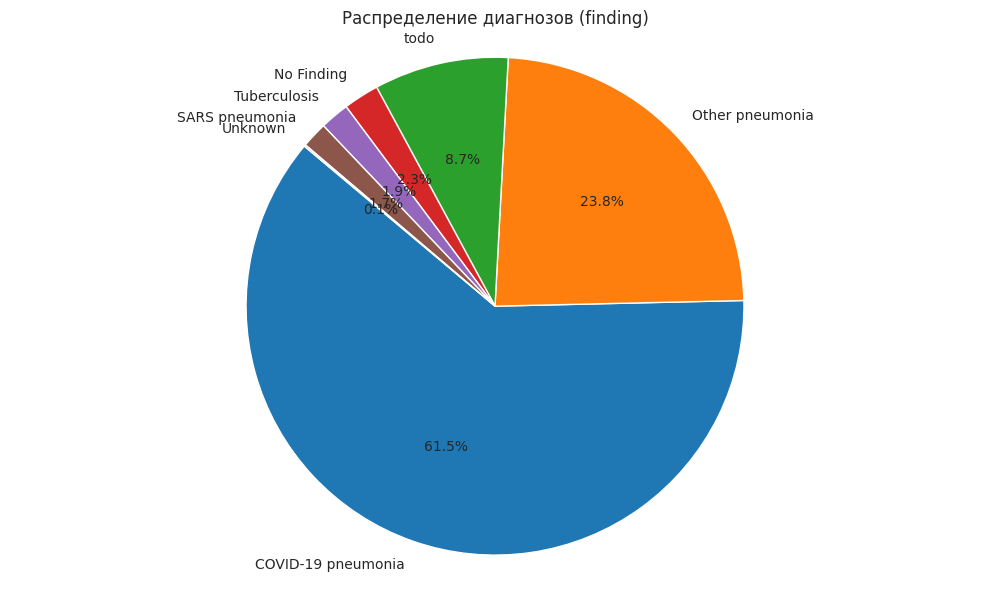

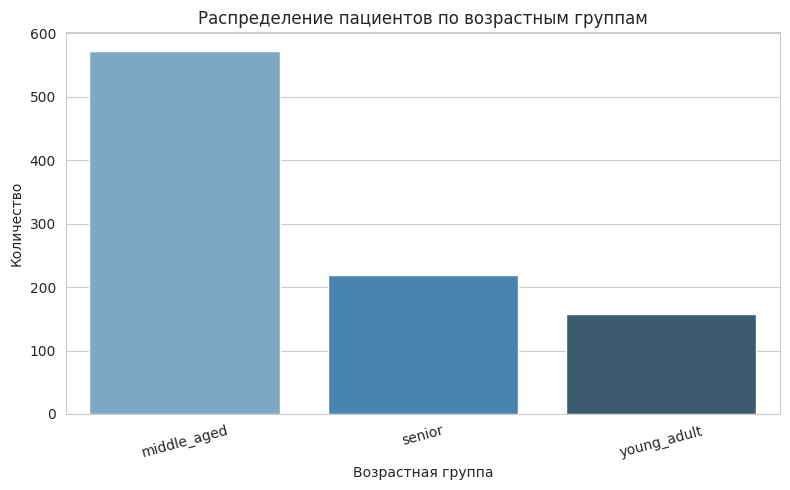

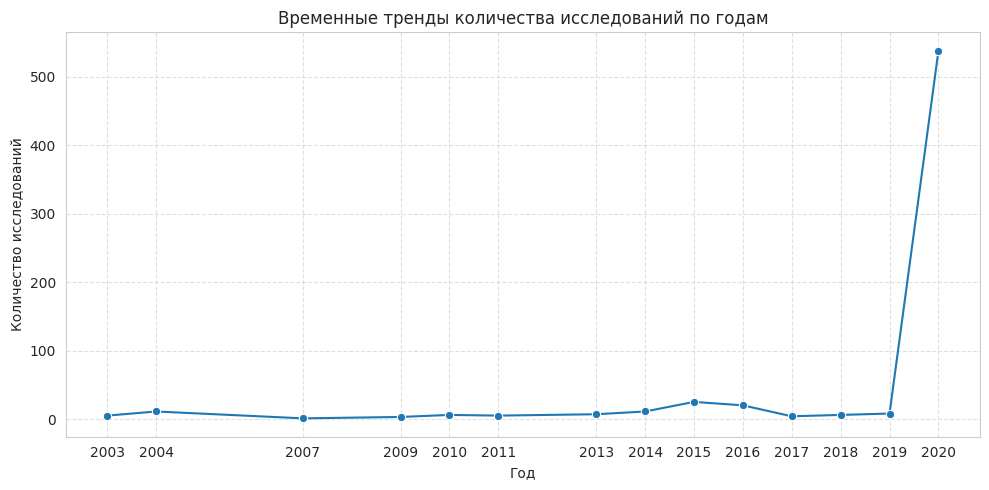

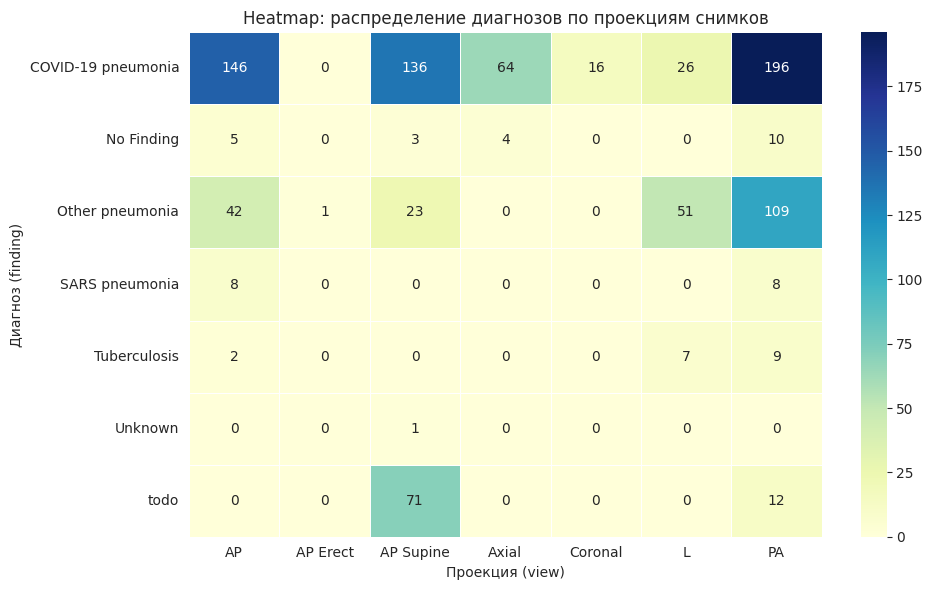

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, when, regexp_extract
from pyspark.sql.types import IntegerType

# Убедимся, что есть колонка year
if "year" not in df_clean.columns:
    df_clean = df_clean.withColumn("year", regexp_extract(col("date"), r"(\d{4})", 1).cast(IntegerTypeId()))

# добавляем колонку age_group БЕЗ UDF
df_viz = df_clean.withColumn(
    "age_group",
    when(col("age").isNull(), "unknown")
    .when((col("age") < 0) | (col("age") > 120), "invalid")
    .when(col("age") < 18, "child")
    .when(col("age") < 40, "young_adult")
    .when(col("age") < 65, "middle_aged")
    .otherwise("senior")
)

# Настройка стиля
plt.rcParams.update({'font.size': 10})
sns.set_style("whitegrid")

# Круговая диаграмма: распределение диагнозов
finding_counts = df_viz.filter(col("finding") != "unknown") \
                       .groupBy("finding").count() \
                       .orderBy("count", ascending=False) \
                       .toPandas()

plt.figure(figsize=(10, 6))
plt.pie(finding_counts['count'], labels=finding_counts['finding'], autopct='%1.1f%%', startangle=140)
plt.title("Распределение диагнозов (finding)")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Столбчатая диаграмма: возрастные группы
age_group_counts = df_viz.filter(col("age_group").isin(["child", "young_adult", "middle_aged", "senior"])) \
                         .groupBy("age_group").count() \
                         .orderBy("count", ascending=False) \
                         .toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=age_group_counts, x='age_group', y='count', palette='Blues_d')
plt.title("Распределение пациентов по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Количество")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Временные тренды: количество исследований по годам
trend_data = df_viz.filter(col("year").isNotNull()) \
                   .groupBy("year") \
                   .count() \
                   .orderBy("year") \
                   .toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(data=trend_data, x='year', y='count', marker='o')
plt.title("Временные тренды количества исследований по годам")
plt.xlabel("Год")
plt.ylabel("Количество исследований")
plt.xticks(trend_data['year'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Heatmap: диагнозы vs проекции снимков
heatmap_data = df_viz.filter(
    (col("finding") != "unknown") &
    (col("view").isNotNull()) &
    (~col("view").isin(["unknown", ""]))
).groupBy("finding", "view").count().toPandas()

# сроим таблицу
pivot_table = heatmap_data.pivot(index="finding", columns="view", values="count").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt="g", cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap: распределение диагнозов по проекциям снимков")
plt.xlabel("Проекция (view)")
plt.ylabel("Диагноз (finding)")
plt.tight_layout()
plt.show()